In [ ]:
"""
<RNN(Recurrent Neural Network, 순환신경망)>
 - RNN은 하나의 계층을 의미함(CNN과 유사함)
 - 하나의 계층 안에서 순환하면서 처리가 된다는 의미로 순환신경망이라는 이름을 사용함
 - 순환신경망은 보통 문자 기반의 텍스트 처리, 시간 단위의 시계열 처리에 보통 사용되고 있음

<RNN의 종류>
 - SimpleRNN(심플순환신경망)
 - LSTM(Long Shot-Term Memory, 장기기억 순환신경망)
 - GRU(Gated Recurrent Unit, 게이트웨이 반복 단위 순환신경망)
 - RNN 신경망의 발전 과정 : SimpleRNN -> LSTM -> GRU
 
<RNN의 특징>
 - 기억이라는 개념이 적용된 신경망임
 - 기존기억 - 현재값 - 다음값 예측 - 오래된 기억 소멸
"""

### 사용할 라이브러리

In [21]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Conv2D, MaxPool2D, Dropout, SimpleRNN, Embedding
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

### 텍스트 길이 정규화 라이브러리
# - 텍스트의 길이가 긴 경우에는 자르고, 길이가 짧은 경우에는 채움
from tensorflow.keras.preprocessing.sequence import pad_sequences


tf.keras.utils.set_random_seed(42)

### 사용할 데이터셋
# - 영화 리뷰 감상평 데이터(긍정/부정)
from keras.datasets import imdb

### 데이터 읽어들이기

In [ ]:
"""
<IMDB : 영화 리뷰 감상평 데이터셋>
 - 실제 리뷰에 대한 텍스트를 숫자(사전 내에 인덱스)화하여 제공하는 데이터임
 - 순환신경망에서 대표적으로 사용되는 샘플 데이터셋으로 미국 영어 문장 데이터임
 - 케라스에서 영어로된 문장을 정수(사전의 인덱스 번호)
  -> 데이터 사전을 -> "말뭉치 사전"이라고 표현합니다.
 - 문장의 각 단어들이 숫자로만 되어 있기 때문에, 영문에 대한 원본 텍스트는 알지 못함
 
 - 각 문장들의 감상평은 "긍정(1)"과 "부정(0)"으로 라벨링(종속변수의 범주)로 되어 있음
 - 총 50,000개의 샘플 데이터로 되어 있으며, 훈련 및 테스트 데이터로 25,000개씩 분리하여 제공해줌
 
 - 데이터를 읽어들일 때 사용할 말뭉치 사전의 인덱스 갯수, 즉 num_words를 500으로 지정
 - 50,000건의 리뷰 문장에 포함된 모든 단어들의 말뭉치 사전 500개 내에 포함되어 있음
"""

In [2]:
### 데이터 수집
(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)

print(train_input.shape, train_target.shape)
print(test_input.shape, test_target.shape)

(25000,) (25000,)
(25000,) (25000,)


In [3]:
### 훈련 0번째 데이터 확인해보기
print(train_input[0])

### 훈련 1번째 데이터의 단어 갯수 확인하기
print(len(train_input[1]))

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]
189


In [ ]:
"""
<각 문장의 단어의 갯수가 모두 다름>
 - 훈련을 위해서는 입력계층에 사용할 input_shape을 지정해야함
  -> 이때 통일된 값을 알고 있어야 지정이 가능함
 - 전체 문장에 대한 단어의 갯수를 통일하기 위한 전처리가 필요함
"""

### 훈련 : 검증 = 8 : 2로 분리하기

In [4]:
### 변수명 : train_input, train_target, val_input, val_target
train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42
)

print(train_input.shape, train_target.shape)
print(val_input.shape, val_target.shape)
print(test_input.shape, test_target.shape)

(20000,) (20000,)
(5000,) (5000,)
(25000,) (25000,)


### 데이터 스케일링(텍스트의 단어의 갯수 통일시키기)

In [5]:
### 모든 데이터의 문장 길이를 확인하여 가장 많이 분포하는 위치를 기준으로 통일시키는 처리를 진행

### 훈련 독립변수의 각 문장데이터들의 문장길이(단어의 갯수)를 확인하여,
# - 하나의 배열에 저장하기
# - 변수명 : lengths
print(len(train_input), len(train_input[0]))

lengths = np.array([ len(x) for x in train_input ])

print(lengths)
print(lengths.shape)

# lengths = []

# for sentence in train_input:
#     lengths.append(len(sentence))

# print(len(lengths)) 
# print(lengths[:10])    

20000 259
[259 520 290 ... 300  70  77]
(20000,)


In [6]:
### 최대값, 최소값, 평균값, 중앙값 확인하기
print(f"최대값 : {max(lengths)} | 최소값 : {min(lengths)} | 평균값 : {lengths.mean()} | 중앙값 : {np.median(lengths)}")

최대값 : 1854 | 최소값 : 11 | 평균값 : 239.00925 | 중앙값 : 178.0


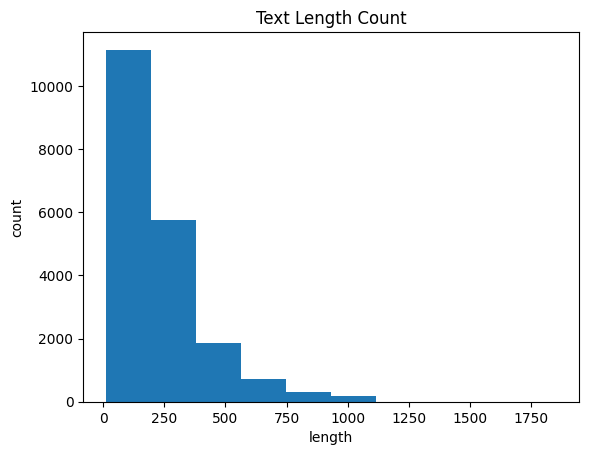

'\n<해석>\n - 단어 갯수의 전반적인 분포는 왼쪽에 편중되어 있음\n - 중앙값 178을 기준으로 분포되어 있는것을 확인할 수 있음\n \n - 훈련을 위해 사용할 표준 길이를 정하기 위한 방법(특정한 방법은 없으며, 데이터 형태를 기준으로 판다)\n  -> 단어 갯수의 최대값(max) 값을 기준으로 정하는 방법\n  -> 단어 갯수들의 중앙값을 기준으로 정하는 방법\n  -> 시각화를 기준으로 분석가의 판단에 의해 정하는 방법\n  \n - 전체적으로 모든 단어를 포함한 기준값 100을 사용(분석가의 결정에 따랐음)\n'

In [7]:
### 히스토그램으로 시각화하기
# - 히스토그램 : 각 데이터의 빈도값(밀집도)으로 표현되는 시각화 막대그래프 모양
#              : hist 함수 사용
# - x 축은 각 문장별 단어의 길이(사이즈) 값
# - y 축은 각 문장별 단어의 길이(사이즈) 빈도
plt.title("Text Length Count")
plt.hist(lengths)
plt.xlabel("length")
plt.ylabel("count")
plt.show()

"""
<해석>
 - 단어 갯수의 전반적인 분포는 왼쪽에 편중되어 있음
 - 중앙값 178을 기준으로 분포되어 있는것을 확인할 수 있음
 
 - 훈련을 위해 사용할 표준 길이를 정하기 위한 방법(특정한 방법은 없으며, 데이터 형태를 기준으로 판다)
  -> 단어 갯수의 최대값(max) 값을 기준으로 정하는 방법
  -> 단어 갯수들의 중앙값을 기준으로 정하는 방법
  -> 시각화를 기준으로 분석가의 판단에 의해 정하는 방법
  
 - 전체적으로 모든 단어를 포함한 기준값 100을 사용(분석가의 결정에 따랐음)
"""

### 각 문장의 단어의 길이(사이즈)를 기준으로 잡은 100개로 통일(스케일링)하기

In [7]:
"""
pad_sequences() : 텍스트의 길이를 기준 값으로 통일시키는 함수
 - 사용되는 속성 : 원본데이터, maxlen
 - 원본데이터 -> 훈련 또는 검증 또는 테스트 데이터
 - maxlen -> 기준값(100)
 
 - maxlen보다 크면 : 100을 초과하는 값들은 제거
 - maxlen보다 작으면 : 0으로 채우기
 
 - 결과값의 차원은 2차원
"""
### 훈련 데이터 스케일링
train_seq = pad_sequences(train_input, maxlen=100)
print(train_seq.shape, train_target.shape)

### 검증 데이터 스케일링
val_seq = pad_sequences(val_input, maxlen=100)
print(val_seq.shape, val_target.shape)

(20000, 100) (20000,)
(5000, 100) (5000,)


In [8]:
### 훈련 데이터 확인
print(train_input[0])
print(train_seq[0])

[1, 73, 89, 81, 25, 60, 2, 6, 20, 141, 17, 14, 31, 127, 12, 60, 28, 2, 2, 66, 45, 6, 20, 15, 497, 8, 79, 17, 491, 8, 112, 6, 2, 20, 17, 2, 2, 4, 436, 20, 9, 2, 6, 2, 7, 493, 2, 6, 185, 250, 24, 55, 2, 5, 23, 350, 7, 15, 82, 24, 15, 2, 66, 10, 10, 45, 2, 15, 4, 20, 2, 8, 30, 17, 2, 5, 2, 17, 2, 190, 4, 20, 9, 43, 32, 99, 2, 18, 15, 8, 157, 46, 17, 2, 4, 2, 5, 2, 9, 32, 2, 5, 2, 267, 17, 73, 17, 2, 36, 26, 400, 43, 2, 83, 4, 2, 247, 74, 83, 4, 250, 2, 82, 4, 96, 4, 250, 2, 8, 32, 4, 2, 9, 184, 2, 13, 384, 48, 14, 16, 147, 2, 59, 62, 69, 2, 12, 46, 50, 9, 53, 2, 74, 2, 11, 14, 31, 151, 10, 10, 4, 20, 9, 2, 364, 352, 5, 45, 6, 2, 2, 33, 269, 8, 2, 142, 2, 5, 2, 17, 73, 17, 204, 5, 2, 19, 55, 2, 2, 92, 66, 104, 14, 20, 93, 76, 2, 151, 33, 4, 58, 12, 188, 2, 151, 12, 215, 69, 224, 142, 73, 237, 6, 2, 7, 2, 2, 188, 2, 103, 14, 31, 10, 10, 451, 7, 2, 5, 2, 80, 91, 2, 30, 2, 34, 14, 20, 151, 50, 26, 131, 49, 2, 84, 46, 50, 37, 80, 79, 6, 2, 46, 7, 14, 20, 10, 10, 470, 158]
[ 10   4  20   9   2 

In [9]:
### 텍스트 제거 또는 채우기 속성 추가
"""
<제거 및 채우기 속성>
 * truncating : maxlen보다 클 때 자르기 속성
  - truncating = "pre" : 앞쪽 제거(기본값으로 사용됨, 생략가능)
  - truncating = "post" : 뒤쪽 제거
  
 * padding : maxlen보다 작을 때 채우기 속성
  - padding = "pre" : 앞쪽을 0으로 채우기(기본값으로 사용됨, 생략가능)
  - padding = "post" : 뒤쪽을 0으로 채우기
"""

### 훈련 데이터 스케일링
train_seq = pad_sequences(train_input, maxlen=100, truncating="post", padding="post")
print(train_seq.shape, train_target.shape)

### 검증 데이터 스케일링
val_seq = pad_sequences(val_input, maxlen=100, truncating="post", padding="post")
print(val_seq.shape, val_target.shape)


(20000, 100) (20000,)
(5000, 100) (5000,)


In [10]:
### 훈련 데이터 확인
print(train_input[0])
print(train_seq[0])

print(train_input[19999])
print(train_seq[19999])

[1, 73, 89, 81, 25, 60, 2, 6, 20, 141, 17, 14, 31, 127, 12, 60, 28, 2, 2, 66, 45, 6, 20, 15, 497, 8, 79, 17, 491, 8, 112, 6, 2, 20, 17, 2, 2, 4, 436, 20, 9, 2, 6, 2, 7, 493, 2, 6, 185, 250, 24, 55, 2, 5, 23, 350, 7, 15, 82, 24, 15, 2, 66, 10, 10, 45, 2, 15, 4, 20, 2, 8, 30, 17, 2, 5, 2, 17, 2, 190, 4, 20, 9, 43, 32, 99, 2, 18, 15, 8, 157, 46, 17, 2, 4, 2, 5, 2, 9, 32, 2, 5, 2, 267, 17, 73, 17, 2, 36, 26, 400, 43, 2, 83, 4, 2, 247, 74, 83, 4, 250, 2, 82, 4, 96, 4, 250, 2, 8, 32, 4, 2, 9, 184, 2, 13, 384, 48, 14, 16, 147, 2, 59, 62, 69, 2, 12, 46, 50, 9, 53, 2, 74, 2, 11, 14, 31, 151, 10, 10, 4, 20, 9, 2, 364, 352, 5, 45, 6, 2, 2, 33, 269, 8, 2, 142, 2, 5, 2, 17, 73, 17, 204, 5, 2, 19, 55, 2, 2, 92, 66, 104, 14, 20, 93, 76, 2, 151, 33, 4, 58, 12, 188, 2, 151, 12, 215, 69, 224, 142, 73, 237, 6, 2, 7, 2, 2, 188, 2, 103, 14, 31, 10, 10, 451, 7, 2, 5, 2, 80, 91, 2, 30, 2, 34, 14, 20, 151, 50, 26, 131, 49, 2, 84, 46, 50, 37, 80, 79, 6, 2, 46, 7, 14, 20, 10, 10, 470, 158]
[  1  73  89  81  25 

### SimpleRNN(심플순환신경망)으로 훈련하기

In [ ]:
"""
<SimpleRNN 계층 설정 방법>
 - 입력 또는 은닉계층으로 사용가능
 - 입력 데이터의 차원(input_shape) = 특성갯수(문자길이), 말뭉치사전갯수로 정의됨
                                   = (100, 500)
"""

In [11]:
### 훈련모델 생성하기
model = Sequential([
    # 입력 계층 생성 (SimpleRNN 계층 사용)
    Input(shape=(100, 500)),
    SimpleRNN(units=8),
    # 출력 계층
    # - 최종 결과는 긍정(1) 또는 부정(0)을 분류한 값이 출력되게 합니다.
    # - 이진분류
    Dense(units=1, activation="sigmoid")
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 4072      
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 4,081
Trainable params: 4,081
Non-trainable params: 0
_________________________________________________________________


In [13]:
### 모델 설정하기(compile)
# - 옵티마이저 : RMSprop사용
# - 학습율 : 0.01 사용
# - 훈련시 정확도 출력
model.compile(
    optimizer = keras.optimizers.RMSprop(learning_rate=0.01),
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

In [14]:
### 저장위치 : model 폴더
# - 저장 파일명 : best_simpleRNN_model.keras
# - 최적의 시점 모델 저장 콜백함수 정의

### 자동종료 콜백함수 정의
# - 자동 종료 시점 확인 : 3

md = ModelCheckpoint(
    "./model/best_simpleRNN_model.keras",
    save_best_only=True
)
es = EarlyStopping(
    patience=3,
    restore_best_weights=True
)

In [15]:
### 훈련 데이터의 차원 확인
train_seq.shape

### 모델 입력계층의 input_shape에는 문자의 갯수, 말뭉치 갯수가 포함된 2차원 데이터를 사용하고 있음
# - 훈련 데이터에는 문자의 갯수만 있음 -> 따라서 말뭉치 500개에 대응하는 차원을 추가해 주어야 합니다.
# - 100개의 문자에 대한 500개 말뭉치와 매핑 작업에 대한 전처리 진행 필요

(20000, 100)

In [ ]:
"""
<RNN에서 사용하는 독립변수 데이터 처리>
 - RNN 모델에서는 독립변수 데이터를 500개의 말뭉치로 매핑해서 훈련을 시켜야 합니다.
 - 매핑 방법 : 원-핫 인코딩, 임베딩 방식 중에 한가지를 사용해서
               매핑 형태로 만들어야 합니다.
             
(원-핫 인코딩(One-Hot Encodigng) 방식)
 - 각 데이터 중에 1개 단어당 말뭉치 사전의 500개와 매핑 (500개 기준으로 원-핫 인코딩 진행)
 - 각 데이터의 단어들이 말뭉치의 몇번째에 위치하는 지를 원-핫인코딩 형태 구조로 변경
 - 사용라이브러리 : keras.util.to_catetorical() 함수 사용
 - 별도로 변환하는 계층은 존재하지 않으며, 프로그램으로 변환해야 합니다.
 - 원-핫 인코딩을 수행하면 특성이 매우 많아지기에, 훈련 처리 속도가 매우 느려지는
   단점이 있으며, 메모리 공간을 많이 차지함
 
(단어 임베딩(Embedding) 방식)
 - 원-핫 인코딩 방식의 단점을 보완하기 위해 개선된 방식임
 - 데이터의 주요 특성들로 모으는 작업을 수행합니다.
   -> 머신러닝의 주성분분석(PCA), CNN의 풀링계층(Pooling Layer)과 유사한 개념임
   -> 주요 특성 : 단어간의 유사도가 가까운 값들을 의미함(유사도가 먼 값들은 제외)
      (예시: 강아지와 고양이, 행복과 좋음 등은 유사한 성격임
             강아지와 행복은 유사한 성격이 아님)
 - Embedding 계층을 사용 : 유사도가 가까운 단어들을 모으는 계층
   
 - 많은 공간을 사용하지 않고 사용함
 - 임베딩 계층을 통해 사용됨 : layer 계층을 추가하여 사용(프로그램 방식 아님)
 - 계층명 : keras.layers.Embedding()
"""

### 원-핫 인코딩 방식으로 변환하여 사용하기

In [16]:
### 훈련데이터를 원핫인코딩으로 변환
train_oh = keras.utils.to_categorical(train_seq)

### 검증데이터를 원핫인코딩으로 변환
val_oh = keras.utils.to_categorical(val_seq)

train_oh.shape, val_oh.shape

((20000, 100, 500), (5000, 100, 500))

In [17]:
### 데이터 확인하기
# - 0번째 문장에 들어있는 값(말뭉치사전의 인덱스 값)
print(train_seq[0])

# - 0번째 문장 중에 0번째 값(말뭉치사전의 인덱스 위치는 1로, 나머지는 0으로)
print(train_oh[0][0])
print(train_oh[0][1])

[  1  73  89  81  25  60   2   6  20 141  17  14  31 127  12  60  28   2
   2  66  45   6  20  15 497   8  79  17 491   8 112   6   2  20  17   2
   2   4 436  20   9   2   6   2   7 493   2   6 185 250  24  55   2   5
  23 350   7  15  82  24  15   2  66  10  10  45   2  15   4  20   2   8
  30  17   2   5   2  17   2 190   4  20   9  43  32  99   2  18  15   8
 157  46  17   2   4   2   5   2   9  32]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.

In [18]:
### 훈련횟수 : 100회, 배치사이즈 64, 검증데이터 사용, 콜백함수 사용
# - 훈련결과는 history 변수에 담기
history = model.fit(train_oh, 
                    train_target,
                    validation_data=(val_oh,
                                     val_target),
                    epochs=100,
                    batch_size=64,
                    callbacks=[md, es]
                  )

Epoch 1/100
313/313 [==============================] - 22s 66ms/step - loss: 0.6839 - accuracy: 0.5615 - val_loss: 0.6805 - val_accuracy: 0.5790
Epoch 2/100
313/313 [==============================] - 19s 62ms/step - loss: 0.6626 - accuracy: 0.6081 - val_loss: 0.6805 - val_accuracy: 0.5622
Epoch 3/100
313/313 [==============================] - 20s 62ms/step - loss: 0.6461 - accuracy: 0.6241 - val_loss: 0.7174 - val_accuracy: 0.5636
Epoch 4/100
313/313 [==============================] - 18s 57ms/step - loss: 0.6290 - accuracy: 0.6553 - val_loss: 0.6363 - val_accuracy: 0.6576
Epoch 5/100
313/313 [==============================] - 18s 57ms/step - loss: 0.6026 - accuracy: 0.6862 - val_loss: 0.6436 - val_accuracy: 0.6454
Epoch 6/100
313/313 [==============================] - 19s 61ms/step - loss: 0.5995 - accuracy: 0.6884 - val_loss: 0.6882 - val_accuracy: 0.5718
Epoch 7/100
313/313 [==============================] - 18s 58ms/step - loss: 0.5860 - accuracy: 0.7003 - val_loss: 0.6559 - val_ac

### 훈련 vs 검증 손실 곡선

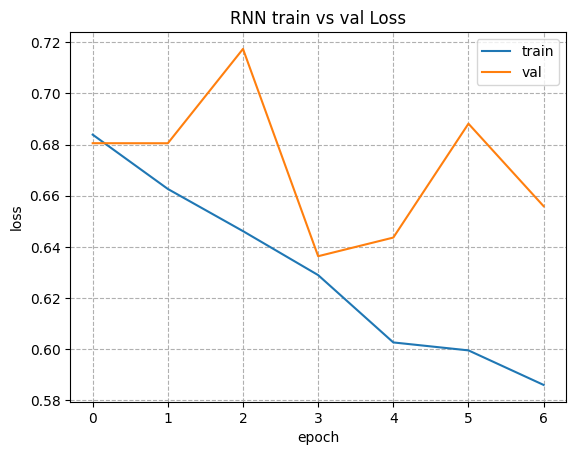

In [19]:
plt.title("RNN train vs val Loss")
plt.plot(history.epoch, history.history["loss"])
plt.plot(history.epoch, history.history["val_loss"])
plt.legend(["train", "val"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid(linestyle="--")
plt.show()

### 훈련 vs 검증 정확도 곡선

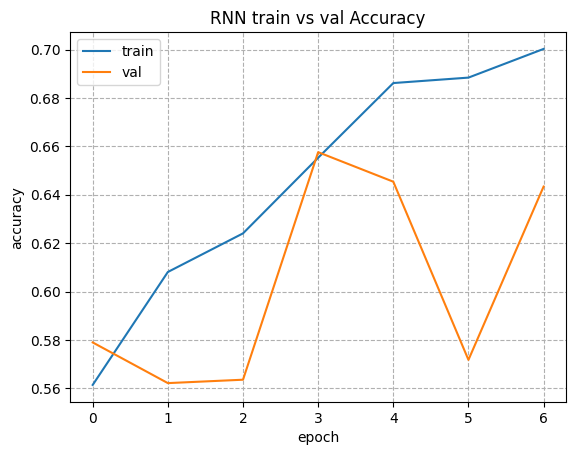

In [20]:
plt.title("RNN train vs val Accuracy")
plt.plot(history.epoch, history.history["accuracy"])
plt.plot(history.epoch, history.history["val_accuracy"])
plt.legend(["train", "val"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid(linestyle="--")
plt.show()

### 단어 임베딩 방식으로 훈련데이터 전처리

In [ ]:
"""
<단어 임베딩 방식>
 - 모델 내에 계층으로 사용되는 계층(훈련에 영향을 미치는 계층입니다.)
 - RNN 계층 전에 위치합니다.
 - 임베딩 계층 속성들
  -> input_dim : 말뭉치 갯수(500)
  -> ouput_dim : 임베딩 크기(주요 특징을 가지는 특성 출력 갯수)
  -> input_length : 사용할 특성의 갯수(각 문장의 단어의 갯수 = 100)
 - RNN 계층 전에 입력계층으로 사용됩니다.
"""

In [ ]:
### 모델 생성하기
model = Sequential([
    # 입력계층(임베딩계층) 생성 및 모델에 추가하기
    Embedding(
        input_dim = 500,
        output_dim = 16,
        input_length = 100
    ),
    # SimpleRNN 계층 추가하기
    SimpleRNN(
        units = 8
    ),
    # 출력계층
    Dense(
        units = 1,
        activation = "sigmoid"
    )
])

model.summary()

"""
 * 임베딩 Param = 말뭉치갯수 * 출력갯수 = 500 * 16 = 8,000
 * SimpleRNN Param = 출력갯수 * (입력갯수 + 출력갯수 + 1)
                   = 
"""

In [23]:
### 모델 설정하기(compile)
model.compile(
    optimizer = keras.optimizers.RMSprop(learning_rate=0.01),
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

### 콜백함수 정의
mc = ModelCheckpoint(
    "./model/best_simpleRNN_embedding_model.keras",
    save_best_only=True
)

es = EarlyStopping(
    patience = 3,
    restore_best_weights=True
)

In [24]:
### 훈련하기
history = model.fit(
    train_seq,
    train_target,
    validation_data=(val_seq,
                     val_target),
    epochs=100,
    batch_size=64,
    callbacks=[mc, es]
)

Epoch 1/100
313/313 [==============================] - 27s 83ms/step - loss: 0.6928 - accuracy: 0.5261 - val_loss: 0.6801 - val_accuracy: 0.5868
Epoch 2/100
313/313 [==============================] - 30s 96ms/step - loss: 0.6702 - accuracy: 0.5917 - val_loss: 0.6852 - val_accuracy: 0.5758
Epoch 3/100
313/313 [==============================] - 28s 88ms/step - loss: 0.6468 - accuracy: 0.6367 - val_loss: 0.6513 - val_accuracy: 0.6370
Epoch 4/100
313/313 [==============================] - 26s 84ms/step - loss: 0.6370 - accuracy: 0.6476 - val_loss: 0.6913 - val_accuracy: 0.5550
Epoch 5/100
313/313 [==============================] - 29s 94ms/step - loss: 0.6257 - accuracy: 0.6640 - val_loss: 0.6578 - val_accuracy: 0.6282
Epoch 6/100
313/313 [==============================] - 29s 92ms/step - loss: 0.6310 - accuracy: 0.6571 - val_loss: 0.6678 - val_accuracy: 0.6200


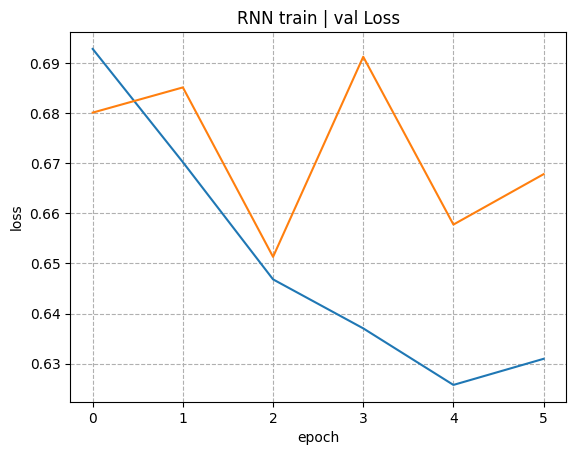

In [25]:
plt.title("RNN train | val Loss")
plt.plot(history.epoch, history.history["loss"])
plt.plot(history.epoch, history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid(linestyle="--")
plt.show()

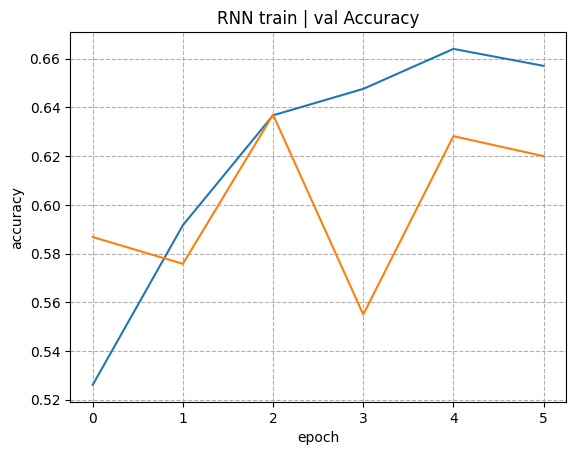

In [26]:
plt.title("RNN train | val Accuracy")
plt.plot(history.epoch, history.history["accuracy"])
plt.plot(history.epoch, history.history["val_accuracy"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid(linestyle="--")
plt.show()

In [31]:
model = Sequential([
    Embedding(
        input_dim = 500,
        output_dim = 16,
        input_length = 100
    ),
    SimpleRNN(
        units = 8
    ),
    Dense(
        units = 64,
        activation ="relu"
    ),
    Dense(
        units = 32,
        activation ="relu"
    ),
    Dense(
        units = 1,
        activation = "sigmoid"
    )
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 16)           8000      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 8)                 200       
                                                                 
 dense_3 (Dense)             (None, 64)                576       
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,841
Trainable params: 8,841
Non-trainable params: 0
_________________________________________________________________


In [34]:
model = Sequential([
    Embedding(
        input_dim = 500,
        output_dim = 16,
        input_length = 100
    ),
    SimpleRNN(
        units = 8
    ),
    Dense(
        units = 1,
        activation = "sigmoid"
    )
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 16)           8000      
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 8)                 200       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,209
Trainable params: 8,209
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

In [ ]:
mc = ModelCheckpoint(
    "./model/best_simpleRNN_embedding_model.keras",
    save_best_only=True
)

es = EarlyStopping(
    patience = 5,
    restore_best_weights=True
)

In [39]:
model.fit(
    train_seq,
    train_target,
    validation_data=(val_seq,
                     val_target),
    epochs=100,
    batch_size=128
    # callbacks=[mc, es]
)

Epoch 1/100
157/157 [==============================] - 13s 80ms/step - loss: 0.6938 - accuracy: 0.5100 - val_loss: 0.6909 - val_accuracy: 0.5286
Epoch 2/100
157/157 [==============================] - 12s 76ms/step - loss: 0.6847 - accuracy: 0.5604 - val_loss: 0.6925 - val_accuracy: 0.5256
Epoch 3/100
157/157 [==============================] - 12s 76ms/step - loss: 0.6732 - accuracy: 0.5882 - val_loss: 0.6958 - val_accuracy: 0.5254
Epoch 4/100
157/157 [==============================] - 12s 76ms/step - loss: 0.6575 - accuracy: 0.6117 - val_loss: 0.6977 - val_accuracy: 0.5388
Epoch 5/100
157/157 [==============================] - 13s 80ms/step - loss: 0.6276 - accuracy: 0.6542 - val_loss: 0.6623 - val_accuracy: 0.6028
Epoch 6/100
157/157 [==============================] - 13s 82ms/step - loss: 0.5918 - accuracy: 0.6930 - val_loss: 0.6490 - val_accuracy: 0.6288
Epoch 7/100
157/157 [==============================] - 13s 82ms/step - loss: 0.5654 - accuracy: 0.7157 - val_loss: 0.6440 - val_ac

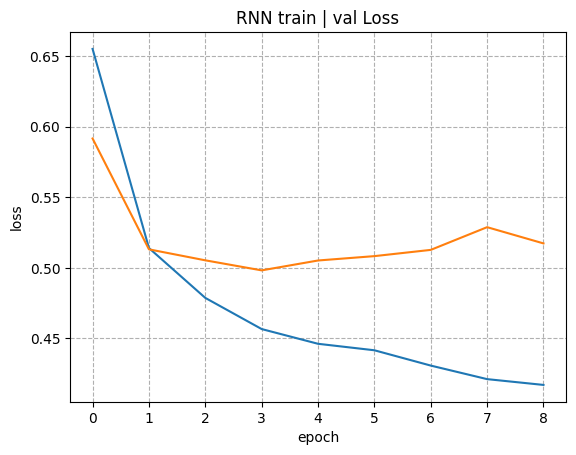

In [40]:
plt.title("RNN train | val Loss")
plt.plot(history.epoch, history.history["loss"])
plt.plot(history.epoch, history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid(linestyle="--")
plt.show()

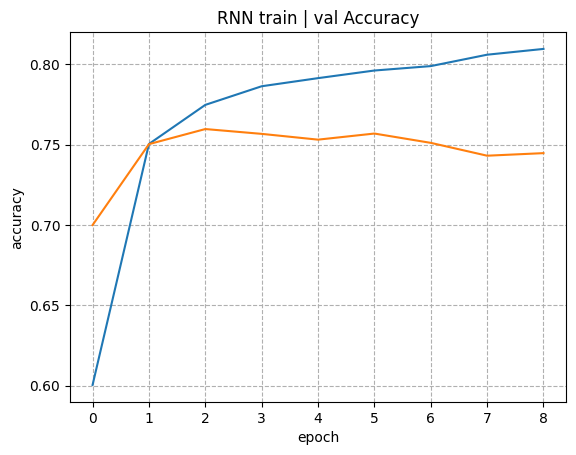

In [41]:
plt.title("RNN train | val Accuracy")
plt.plot(history.epoch, history.history["accuracy"])
plt.plot(history.epoch, history.history["val_accuracy"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid(linestyle="--")
plt.show()